# Keyword spotter

A simple project on speech recognition.

Sebastian Thomas (datascience at sebastianthomas dot de)

## Origin

The project is an extension of the introductory tutorial on speech command recognition from Tensorflow.[introductory tutorial on speech command recognition from Tensorflow](https://www.tensorflow.org/datasets/catalog/speech_commands)

It uses the [speech_commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) of Pete Warden, version 0.0.2. The dataset contains 105829 [WAV files](https://en.wikipedia.org/wiki/WAV), each of a duration of at most 1 second. Each file consists of a spoken command out of a list of 35 commands.

Warden, Pete: Speech Commands: A Dataset for Limited-Vocabulary Speech Recognition. arXiv, 2018. [arXiv:1804.03209](https://arxiv.org/abs/1804.03209)


## Goal

We essentially follow Warden's approach, that is, our goal is to classify each file as one of ten prechosen commands ('Yes', 'No', 'Up', 'Down', 'Left', 'Right', 'On', 'Off', 'Stop' and 'Go') or as an unknown command.

# Part 1: Setup

We import the modules we will use, download the data and distribute it into folders for training, validation and testing.

## Imports

In [1]:
from __future__ import annotations


# type hints
from typing import Union, NoReturn, Tuple, List, Iterable

# python tools
from functools import partial
from itertools import product

# math
from math import ceil

# randomness
import random

# paths
from pathlib import PurePath, Path

# hashing
import hashlib

# regular expressions
import re

# operating system
import os
from os import PathLike

# data
import numpy as np

# signal processing
import librosa

# machine learning
import tensorflow as tf
from tensorflow.data import Dataset as TensorflowDataset
import tensorflow.keras as keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, \
    MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.python.keras.callbacks import History

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Data mining

In [2]:
DATA_DIR = Path('data', 'speech_commands', '0.0.2')
if not DATA_DIR.exists():
    DATA_FILE = 'speech_commands_v0.02.tar.gz'
    URL = os.path.join('http://download.tensorflow.org/data', DATA_FILE)

    # download compressed file and extract it
    keras.utils.get_file(DATA_FILE, URL, extract=True, cache_dir='.',
                         cache_subdir=DATA_DIR)
    DATA_DIR.joinpath(DATA_FILE).unlink()

    # make directories for the data parts
    for part in ('training', 'validation', 'testing'):
        DATA_DIR.joinpath(part).mkdir(exist_ok=True)

    # define subdirectories for the categories
    subdirs = (file for file in DATA_DIRdata_dir.iterdir() if file.is_dir()
               and file.name not in {'_background_noise_', 'training',
                                     'validation', 'testing'})

    # distribute files into the directories for the data parts
    # the algorithm for the distribution is taken
    # from data/speech_commands/0.0.2/README.md
    MAX_NUM_WAVS_PER_CLASS = 2**27 - 1  # ~134M

    def data_part(file: PurePath, val_size: float = 0.1,
                  test_size: float = 0.1) -> str:
        """Determines which data part the file should belong to."""

        hash_name = re.sub(r'_nohash_.*$', '', file.name)
        hash_value = int(hashlib.sha1(hash_name.encode('utf-8')).hexdigest(),
                         base=16) % (MAX_NUM_WAVS_PER_CLASS + 1)
        percentage = hash_value / MAX_NUM_WAVS_PER_CLASS

        if percentage < val_size:
            return 'validation'
        elif percentage < val_size + test_size:
            return 'testing'
        else:
            return 'training'

    for subdir in subdirs:
        for part in ('training', 'validation', 'testing'):
            DATA_DIR.joinpath(part, subdir.name).mkdir(exist_ok=True)
        for file in subdir.iterdir():
            file.rename(
                DATA_DIR.joinpath(data_part(file), subdir.name, file.name))
        subdir.rmdir()

# Part 2: Preprocessing

We define functions for constructing TensorFlow datasets.

## Background noises

This is future work.

In [3]:
# future work:
# BACKGROUND_NOISE_DIR = DATA_DIR.joinpath('_background_noise_')
# BACKGROUND_NOISE_SIGNALS = [librosa.load(file, sr=None)[0]
#                             for file in BACKGROUND_NOISE_DIR.glob('*.wav')]

## Datasets

The datasets for training, validation and testing are build as follows:
1. Generators yielding the file paths are constructed. This is done by the function `get_files`.
2. These generators are used to construct corresponding TensorFlow dataset. This is done by the function `build_files_dataset`. These datasets are prepared for shuffling at the beginning of each epoch during training.
3. Each file path is used to construct features and a target label. The construction of the features is done in the function `to_mfcc`. The construction of the target is done in the function `to_label`. The features are so-called [Mel Frequency Cepstral Coefficients](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum), which are organised in a tensor of rank 2 and therefore may be visualized as a (grayscale) image.
4. Finally, the files datasets are mapped to datasets containing tuples of features and targets. This is done in the function `build_dataset`, which applies the functions `to_mfcc` and `to_label` to each instance of the corresponding file path datasets.

In [4]:
COMMANDS = ('yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop',
            'go')
CATEGORIES = COMMANDS + ('unknown', 'silence')

NUM_SAMPLES = 16000
NUM_CATEGORIES = len(CATEGORIES) - 1
# disregard category 'silence' for now (future work)

In [5]:
def get_files(part: bytes) -> Iterable[PathLike]:
    """Yields paths of files of a part of the data as a string.

    The parameter part is supposed to be either 'training' or 'validation' or
    'testing'."""
    
    for file in DATA_DIR.joinpath(part.decode('utf-8')).glob('*/*.wav'):
        yield str(file)


def to_mfcc(file: PathLike, n_mfcc: int = 13, hop_length: int = 512,
            n_fft: int = 2048) -> np.ndarray:
    """Returns the mel frequency cepstral coefficients of the sound file at the
    given path, using the given parameters."""

    signal, _ = librosa.load(file, sr=None)
    padded_signal = np.concatenate((signal,
                                    np.zeros(NUM_SAMPLES - len(signal))))

    return librosa.feature.mfcc(padded_signal, sr=NUM_SAMPLES, n_mfcc=n_mfcc,
                                hop_length=hop_length, n_fft=n_fft).T


def to_label(path: PurePath) -> int:
    """Returns the label of the sound file at the given path."""
    
    command = path.parent.name
    category = command if command in COMMANDS else 'unknown'

    return np.argmax(category == np.array(CATEGORIES))


def build_files_dataset(part: bytes) -> TensorflowDataset:
    """Returns a tensorflow dataset consisting of the file paths of the given
    part of the dataset.

    The parameter part is supposed to be b'training' or b'validation' or
    b'testing'."""

    output_signature = tf.TensorSpec(shape=(), dtype=tf.string)
    ds = TensorflowDataset.from_generator(get_files, args=(part,),
                                          output_signature=output_signature)
    count = sum(1 for _ in get_files(part))
    ds = ds.shuffle(buffer_size=count, seed=0, reshuffle_each_iteration=True)
    return ds


def build_dataset(part: bytes, batch_size=64, n_mfcc: int = 13,
                  hop_length: int = 512, n_fft: int = 2048) \
        -> TensorflowDataset:
    """Returns a tensorflow dataset consisting of pairs of mfcc features and
    labels.

    The parameter part is supposed to be b'training' or b'validation' or
    b'testing'."""    

    def to_features_and_target(file: tf.Tensor) -> Tuple[np.ndarray, np.int64]:
        file = PurePath(file.numpy().decode('utf-8'))
        return np.expand_dims(to_mfcc(file, n_mfcc=n_mfcc,
                                      hop_length=hop_length, n_fft=n_fft),
                              -1), to_label(file)

    def tf_to_features_and_target(file: tf.Tensor) -> List[tf.Tensor]:
        features, target = tf.py_function(to_features_and_target, [file],
                                          (tf.float64, tf.int8))
        features.set_shape((ceil(NUM_SAMPLES / hop_length), n_mfcc, 1))
        target.set_shape(())
        return features, target

    files_ds = build_files_dataset(part)

    ds = files_ds.map(tf_to_features_and_target)
    ds = ds.batch(batch_size)
    ds = ds.cache()
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# Part 3: Training

As our features may be interpreted as grayscale images, we use convolutional neural nets for classification.

## Building functions

In [6]:
class Conv2DBlock(Model):
    """A convolutional block consisting of a convolutional layer, a batch
    normalization layer and a max pooling layer."""
    
    def __init__(self, filters: int,
                 kernel_size: Union[int, Tuple[int, int], List[int]] = 3,
                 padding: str = 'valid',
                 activation: Union[function, str] = 'relu',
                 kernel_regularizer: Union[Regularizer, NoneType] = None,
                 pool_size: Union[int, Tuple[int, int]] = 2,
                 strides: Union[int, Tuple[int, int], NoneType] = None,
                 name: Union[str, NoneType] = None):
        """Initializes this instance."""

        super().__init__(name=name)

        self._conv = Conv2D(filters, kernel_size, padding=padding,
                            activation=activation,
                            kernel_regularizer=kernel_regularizer,
                            name=self.name + '__conv')
        self._batch_normalization = BatchNormalization(
            name=self.name + '__batch_normalization')
        self._max_pool = MaxPool2D(pool_size, strides=strides,
                                   name=self.name + '__max_pool')

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        """Returns the result of a forward pass through this instance."""
        
        return self._max_pool(self._batch_normalization(self._conv(inputs)))

    def get_config(self) -> dict:
        """Returns config data in form of a JSON-serializable dictionary."""
        
        conv_layer_config = self._conv.get_config()
        return {'filters': self._conv.filters,
                'kernel_size': self._conv.kernel_size,
                'padding': self._conv.padding,
                'activation': conv_layer_config['activation'],
                'kernel_regularizer': conv_layer_config['kernel_regularizer'],
                'pool_size': self._max_pool.pool_size,
                'strides': self._max_pool.strides,
                'name': self.name}

    @classmethod
    def from_config(cls, config: dict) -> Conv2DBlock:
        """Constructs instance from config data."""
        
        return cls(**config)


def build_classifier(input_shape: Tuple) -> Model:
    """Returns a CNN classifier."""
    
    return Sequential([
        Input(shape=input_shape),
        Conv2DBlock(16, padding='same', kernel_regularizer=L2(0.001)),
        Conv2DBlock(32, padding='same', kernel_regularizer=L2(0.001)),
        Conv2DBlock(64, padding='same', kernel_regularizer=L2(0.001)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(NUM_CATEGORIES)
    ])


def build_compiled_classifier(input_shape: Tuple,
                              learning_rate: float = 0.001) -> Model:
    """Returns a compiled CNN classifier."""

    classifier = build_classifier(input_shape)

    classifier.compile(optimizer=Adam(learning_rate=learning_rate),
                       loss=SparseCategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])

    return classifier

## Visualization function

To visualize the results of a training process, we will use the following function.

In [7]:
def plot_history(history: History) -> NoReturn:
    """Plots loss and accuracy of the training and validation datasets."""

    _, axes = plt.subplots(1, 2, figsize=(17, 6))

    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('loss')
    axes[0].legend(['train', 'val'], loc='upper right')

    axes[1].plot(history.history['accuracy'])
    axes[1].plot(history.history['val_accuracy'])
    axes[1].set_xlabel('epoch')
    axes[1].set_ylabel('accuracy')
    axes[1].legend(['train', 'val'], loc='lower right')

    plt.show()

## Feature and model selection

We train some classifiers using different counts of features and different learning rates.

n_mfcc = 13, learning_rate = 0.001
Validation loss: 0.290, validation accuracy: 0.941


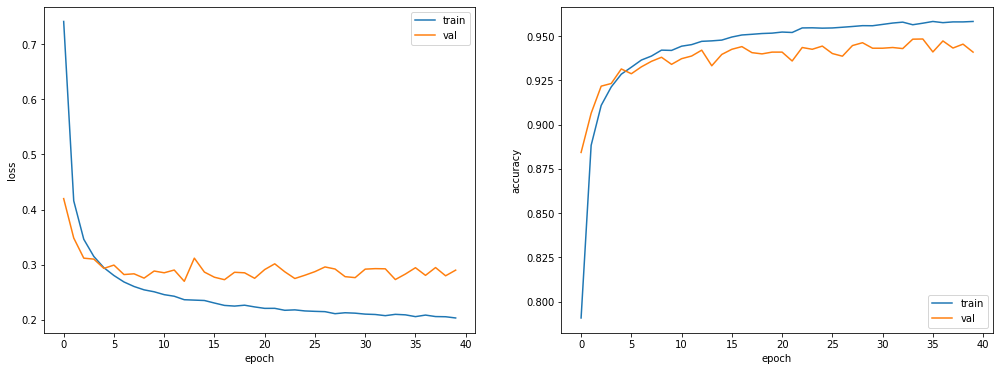

n_mfcc = 13, learning_rate = 0.0001
Validation loss: 0.287, validation accuracy: 0.944


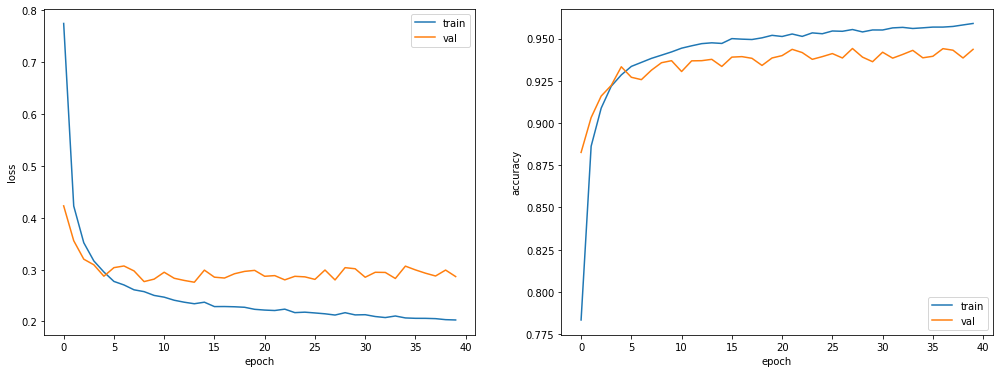

n_mfcc = 20, learning_rate = 0.001
Validation loss: 0.293, validation accuracy: 0.937


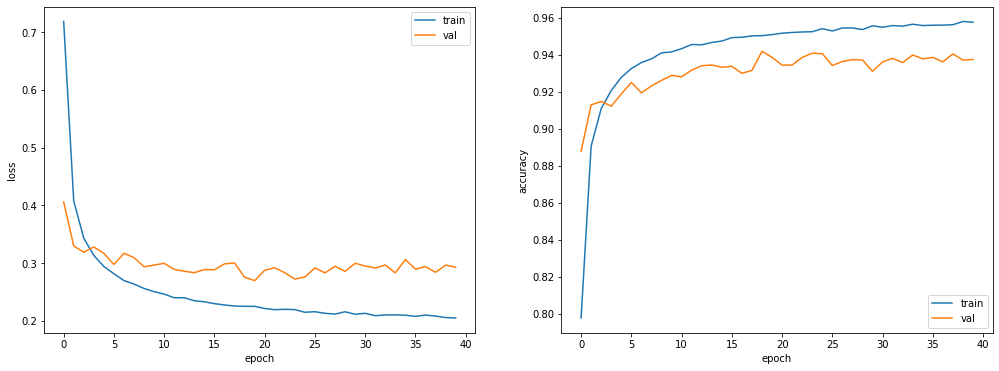

n_mfcc = 20, learning_rate = 0.0001
Validation loss: 0.321, validation accuracy: 0.936


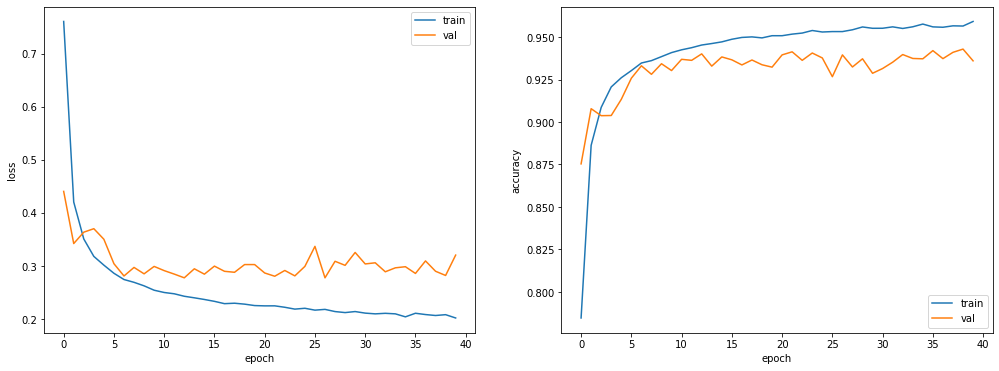

n_mfcc = 25, learning_rate = 0.001
Validation loss: 0.295, validation accuracy: 0.940


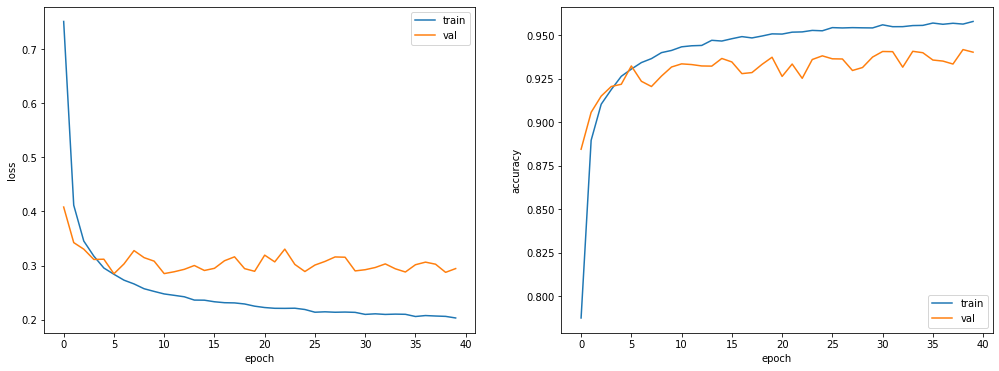

n_mfcc = 25, learning_rate = 0.0001
Validation loss: 0.291, validation accuracy: 0.935


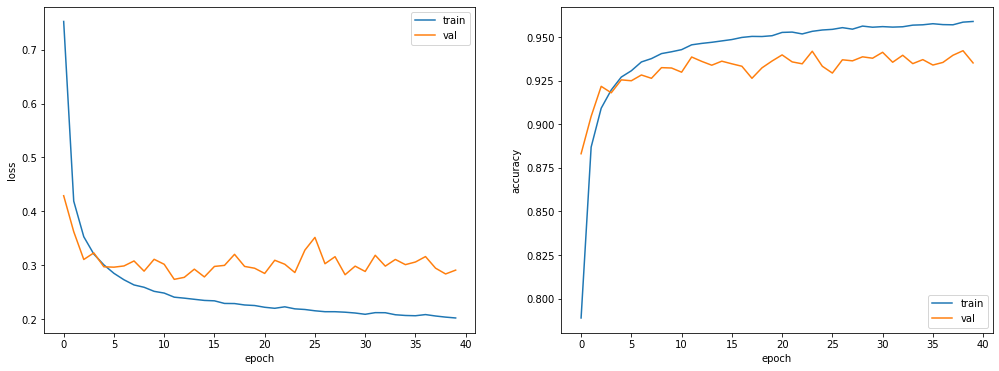

n_mfcc = 30, learning_rate = 0.001
Validation loss: 0.289, validation accuracy: 0.942


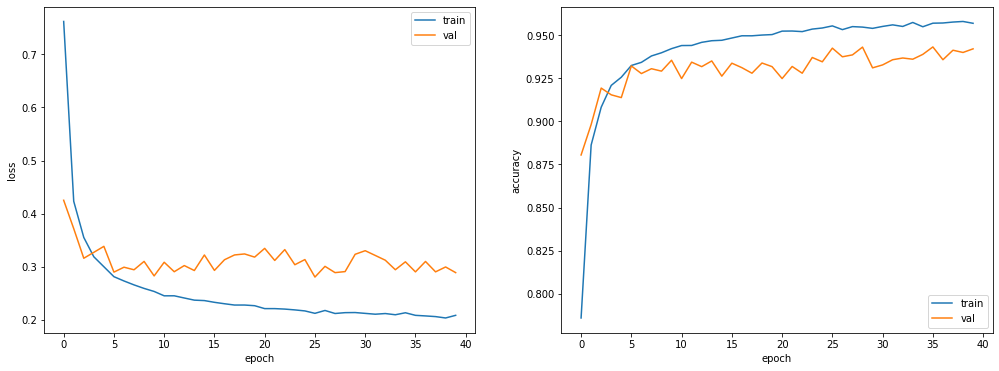

n_mfcc = 30, learning_rate = 0.0001
Validation loss: 0.288, validation accuracy: 0.940


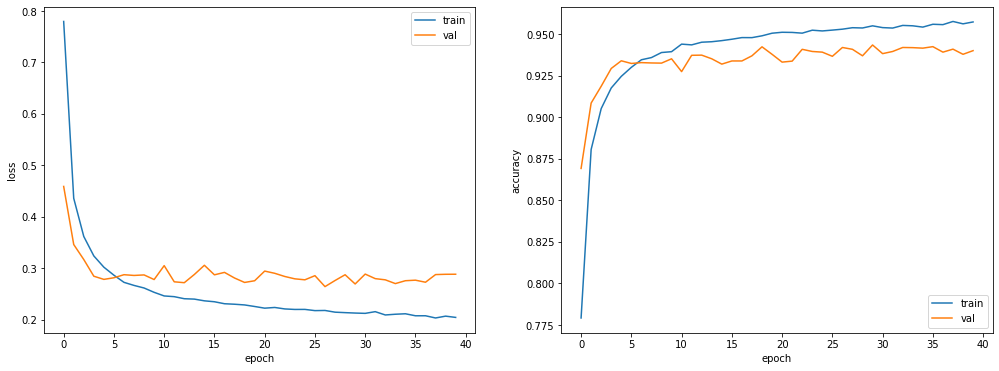

In [8]:
for n_mfcc, learning_rate in product((13, 20, 25, 30), (0.001, 0.0001)):
    print(f'n_mfcc = {n_mfcc}, learning_rate = {learning_rate}')
    train_ds = build_dataset(b'training')
    val_ds = build_dataset(b'validation')

    sample_features, _ = next(iter(train_ds))
    input_shape = sample_features.shape[1:]

    classifier = build_compiled_classifier(input_shape)

    history = classifier.fit(train_ds, epochs=40, verbose=0,
                             validation_data=val_ds)

    print('Validation loss: {:.3f}, validation accuracy: {:.3f}'.format(
        history.history['val_loss'][-1], history.history['val_accuracy'][-1]))

    plot_history(history)

Result: After 40 epochs, all accuracies are in the range between 0.935 and 0.944. Since the accuracies essentially oscillate a few epochs (5 to 20) and since the trained classifiers are overfitted, we choose the first configuration of hyperparameters, i.e `n_mfcc = 13`, `learning_rate = 0.001`, but train the classifier only for `15` epochs.

# Part 5: Evaluation

We retrain a classifier with the hyperparameters `n_mfcc = 13`, `learning_rate = 0.001`, `epochs = 15`, evaluate it on the testing dataset and visualize the confusion matrix.

In [9]:
CLASSIFIER_PATH = 'classifier.tf'

train_ds = build_dataset(b'training')
test_ds = build_dataset(b'testing')

sample_features, _ = next(iter(train_ds))
input_shape = sample_features.shape[1:]

classifier = build_compiled_classifier(input_shape)

history = classifier.fit(train_ds, epochs=15, verbose=0)

classifier.save(CLASSIFIER_PATH)

test_loss, test_accuracy = classifier.evaluate(test_ds, verbose=0)
print('Test loss: {:.3f}, test accuracy: {:.3f}'.format(test_loss,
                                                        test_accuracy))

Test loss: 0.291, test accuracy: 0.934


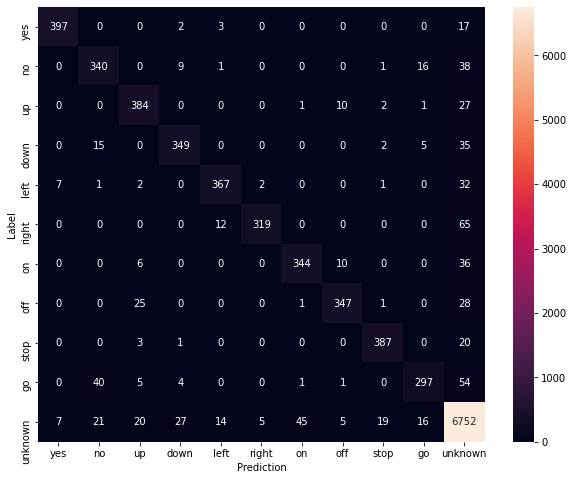

In [10]:
# compute confusion matrix
confusion_matrix = tf.zeros((NUM_CATEGORIES, NUM_CATEGORIES), dtype=tf.int32)
for features, labels in test_ds:
    confusion_matrix += tf.math.confusion_matrix(
        labels, tf.argmax(classifier.predict(features), axis=1),
        num_classes=NUM_CATEGORIES)

# plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, xticklabels=CATEGORIES[:-1],
            yticklabels=CATEGORIES[:-1],
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Future work

- tune more hyperparameters
- use class weights for training (we have imbalanced classes)
- add background noise to the instances
- use other form of data augmentation such as e.g time shifting
- add a silence label
- consider other classifier models